# Deploy a Keras Model with Azure ML
Use the **Python 3.6** environment

In [1]:
# install h5py (needed by Keras to save model -  seems to be missing/corrupt in DSVM Python 3.6 environment)
import sys
! {sys.executable} -m pip install h5py --upgrade

# (ignore any errors)

    100% |████████████████████████████████| 2.8MB 15.7MB/s ta 0:00:01
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [2]:
## Keras and Tensorflow environment
import tensorflow
import keras

print ("Tensorflow:",tensorflow.__version__)
print("Keras:", keras.__version__)

from keras import backend as K

Using TensorFlow backend.


Tensorflow: 1.12.0
Keras: 2.1.5


In [3]:
# Prepare the image data sets
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

def load_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    c = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            # use the folder name as the class name for this label
            print(d,'...')
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                features.append(img)
                labels = np.append(labels, c)
            c = c + 1
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
print("Loading data...")
features, labels, classnames = load_data('resized_images')

# split into training and testing sets
print("Splitting data...")
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

#Format features
print("Pre-processing data...")
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

# Format labels
y_train = np_utils.to_categorical(y_train, len(classnames))
y_train = y_train.astype('float32')
y_test = np_utils.to_categorical(y_test, len(classnames))
y_test = y_test.astype('float32')

print("Data ready for training.")

Loading data...
axes ...
rope ...
harnesses ...
gloves ...
crampons ...
hardshell_jackets ...
insulated_jackets ...
boots ...
tents ...
carabiners ...
helmets ...
pulleys ...
Splitting data...
Pre-processing data...
Data ready for training.


Defining model...
Training model...
Train on 1485 samples, validate on 637 samples
Epoch 1/20
1485/1485 [==============================] - 21s 14ms/step - loss: 2.3104 - acc: 0.1960 - val_loss: 2.0590 - val_acc: 0.2386
Epoch 2/20
1485/1485 [==============================] - 2s 1ms/step - loss: 1.7564 - acc: 0.2067 - val_loss: 1.4295 - val_acc: 0.2386
Epoch 3/20
1485/1485 [==============================] - 2s 1ms/step - loss: 1.3392 - acc: 0.2067 - val_loss: 1.2252 - val_acc: 0.2512
Epoch 4/20
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1241 - acc: 0.3818 - val_loss: 0.7929 - val_acc: 0.7253
Epoch 5/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.6898 - acc: 0.7684 - val_loss: 0.6366 - val_acc: 0.7928
Epoch 6/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5203 - acc: 0.8148 - val_loss: 0.6016 - val_acc: 0.7739
Epoch 7/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5167 - acc: 0.8135 - val_loss: 0.

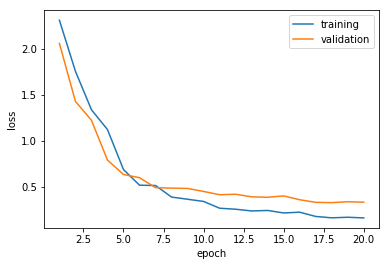

In [4]:
# Train a CNN classifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from matplotlib import pyplot as plt
%matplotlib inline

# Define the model layers
print("Defining model...")
model = Sequential()
model.add(Conv2D(32, (6, 6), input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(len(classnames), activation='sigmoid'))

# Compile and train the model
print("Training model...")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
num_epochs = 20 
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=64, validation_data=(x_test, y_test))

# Plot loss
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

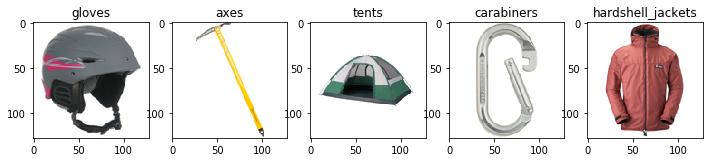

In [7]:
# Test the model locally

def resize_image(img, size):
    from PIL import Image, ImageOps 
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg

def predict_image(classifier, img):
    import numpy as np
    
    # Flatten the image data to correct feature format
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the classifier to predict the class
    predicted_class = classifier.predict(imgfeatures)
    i = np.argmax(predicted_class, axis=1)
    return i



# Save and reload the model
from keras.models import load_model

modelFileName = 'adventureworks-kerasTF.h5'

model.save(modelFileName) # saves the compiled model
del model  # deletes the existing model variable

model = load_model(modelFileName) # loads the saved model


# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image_urls = []
image_urls.append('http://images.the-house.com/giro-g10mx-mtgy-07.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    
    # Load the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    
    # Resize the image so it matches the training set
    img = np.array(resize_image(img, size))
    
    # Use the model to predict the image class 
    class_idx = predict_image(model, img)
    
    # Get the corresponding class name
    class_name = classnames[class_idx[0]]
    
    # Display the image with its predicted class name
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)

In [8]:
# Replace YOUR_SUBSCRIPTION_KEY in the following variable assignment:
SUBSCRIPTION_ID = 'YOUR_SUBSCRIPTION_KEY'

In [9]:
# Check Azure ML SDK version
import azureml.core
print(azureml.core.VERSION)

1.0.2


In [ ]:
# Create an Azure ML Workspace in your Azure subscription
from azureml.core import Workspace
ws = Workspace.create(name='my_aml_workspace', # or another name of your choosing
                      subscription_id=SUBSCRIPTION_ID,
                      resource_group='aml_resources', # or another name of your choosing
                      create_resource_group=True,
                      location='eastus2' # or other supported Azure region
                     )

# Sign in using the link and code returned by this cell...

In [11]:
from azureml.core import Workspace

# Save the workspace config
ws.write_config()

# Reconnect to the workspace (if you're not already signed in, you'll be prompted to authenticate with a code as before)
ws = Workspace.from_config()

Wrote the config file config.json to: /data/home/graeme/notebooks/openhack/aml_config/config.json
Found the config file in: /data/home/graeme/notebooks/openhack/aml_config/config.json


In [12]:
%%writefile score.py
# scoring script used by service to load model and generate prediction
import json
import numpy as np
import os
from keras.models import load_model
from azureml.core.model import Model

# Called when the service is loaded
def init():
    global model
    # Get the path to the deployed model file and load it
    model_path = Model.get_model_path('adventureworks-kerasTF.h5')
    model = load_model(model_path)

# Called when a request is received
def run(raw_data):
    # Get the input data - the image(s) to be classified.
    data = np.array(json.loads(raw_data)['data'])
    # Get a prediction from the model
    class_probabilities = model.predict(data)
    return json.dumps(class_probabilities.tolist())



Writing score.py


In [13]:
from azureml.core.conda_dependencies import CondaDependencies
# Environment config so that depedencies get installed in container

myenv = CondaDependencies()
myenv.add_conda_package("keras")

env_file = "env.yml"

with open(env_file,"w") as f:
    f.write(myenv.serialize_to_string())
print("Saved dependency info in", env_file)

Saved dependency info in env.yml


In [14]:
from azureml.core.image import ContainerImage
# Define an image for the container, including the scoring script and dependencies file

image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "env.yml",
                                                  description = "Container image for shape classification",
                                                  tags = {"data": "shapes", "type": "classification"}
                                                 )
print(image_config)

In [15]:
from azureml.core.webservice import AciWebservice
# Define config for deploying the container image as an ACI web service

aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {"data": "shapes", "type": "classification"},
                                               description = 'shape classification service')
print(aci_config)

In [16]:
from azureml.core.webservice import Webservice
# Register the model file and deploy the service, wait for a "Healthy" status

service_name = 'adventureworks-svc'
service = Webservice.deploy(deployment_config = aci_config,
                                image_config = image_config,
                                model_paths = [modelFileName],
                                name = service_name,
                                workspace = ws)

service.wait_for_deployment(show_output = True)
print(service.state)

Registering model adventureworks-kerasTF.h5
Creating image
Image creation operation finished for image adventureworks-svc:1, operation "Succeeded"
Creating service
Running.....................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


gloves


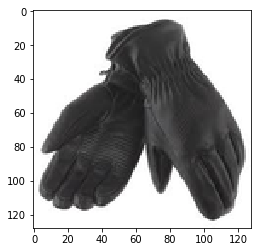

In [17]:
# Use the web service to predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import json

# Get a new test image
image_url = 'https://upload.wikimedia.org/wikipedia/commons/8/82/Skiglove.png'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
    
# Pre-process the image so it matches the training set (which is an array of images)
size = (128,128)
img = np.array(resize_image(img, size))
imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
imgfeatures = imgfeatures.astype('float32')
imgfeatures /= 255

# Convert the array of images to a list and serialize as JSON
input_json = json.dumps({"data": imgfeatures.tolist()})

# Encode the input data as an array of bytes
input_bytes = bytes(input_json, encoding = 'utf8')

# Call the web service, passing the input data
service_response = service.run(input_data = input_bytes)
    
# Get the returned predictions 
predictions = json.loads(service_response)

# We only submitted one image, so get the first prediction
class_probabilitites = predictions[0]

# Get the highest class probability
class_idx = np.argmax(np.array(class_probabilitites))

# Get the corresponding class name
predicted_class = classnames[int(class_idx)]

# Print the results
print(predicted_class)
imgplot = plt.imshow(img)


In [18]:
# Delete the service and workspace when finished with it
service.delete()
rg = ws.resource_group
print("Service deleted. If you're finished with your Azure ML workspace, you should delete the %s resource group in your Azure subscription." % rg)

Service deleted. If you're finished with your Azure ML workspace, you should delete the aml_resources resource group in your Azure subscription.
